## Riminder Technical Assessment
**Author: Jorge Quintana**
<br>
**Date: July 23rd, 2018**
<hr>

## Set Up

Loading the JSON file with the data related to the labels for Computer Vision task.

In [49]:
import warnings
warnings.filterwarnings("ignore")

import json
from os import listdir
from PIL import Image as PImage
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

print("Numpy version: " + str(np.__version__))
print("Seaborn version: " + str(sns.__version__))
print("JSON version: " + str(json.__version__))
print("TensorFlow version: " + str(tf.__version__))

Numpy version: 1.14.3
Seaborn version: 0.8.0
JSON version: 2.0.9
TensorFlow version: 1.8.0


<hr>
## Data Exploration and Pre-processing

A dictionary is created using the following structure: {Image, Label}. With that structure is easy to access the full information about the images, such as name, image itself and label. Internally the dictionary has a Numpy array with the RGB information of each picture and the label as a string. On the other, and as a quality and consistency measure, two auxiliar arrays are created to save the dimensions of each picture, n and m.

In [12]:
def load_and_label(local: bool):
    if local:
        path = "sample/"
    else:
        path = "riminder-test-vision-blanked-resumes-labelled/"

    with open("riminder-test-vision-blanked-resumes-labels.json", "r") as read_file:
        labels = json.load(read_file)
    
    images_list = listdir(path)
    image = np.array(PImage.open(path + images_list[0]))
    images = [image]
    label = [labels[images_list[0]]]
    n = []
    m = []

    for img in images_list[1:]:
        image = np.array(PImage.open(path + img))
        images.append(image)
        label.append(labels[img])
        n.append(image.shape[0])
        m.append(image.shape[1])
    return images, label, n, m
    
images, labels, n, m = load_and_label(local = False)
print("Number of images loaded and labeled: " + str(len(images)))

Number of images loaded and labeled: 1655


The loaded pictures look like this:

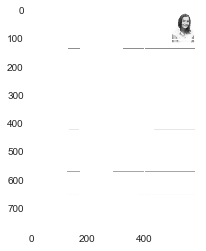

In [15]:
plt.figure()
plt.imshow(images[0])
plt.show()

After loading the pictures and labels we need to explore the dimensions of pictures in order to identify if the whole pictures have the same sizes. To do so, two histograms for the pictures' sizes and mode computation are shown below.

The mode for Height is: ModeResult(mode=array([840]), count=array([934]))
The mode for Width is: ModeResult(mode=array([594]), count=array([917]))


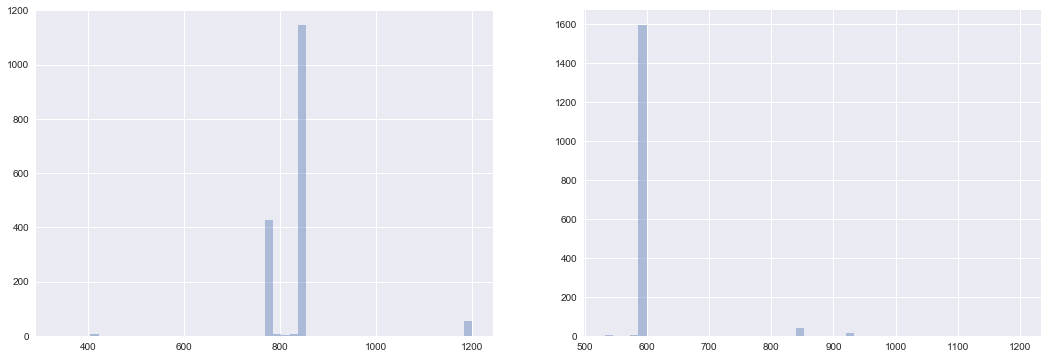

In [44]:
sns.set(color_codes = True)
f, axes = plt.subplots(1, 2)
f.set_size_inches(18, 6)

sns.distplot(n, kde=False, rug=False, ax=axes[0])
sns.distplot(m, kde=False, rug=False, ax=axes[1])

print("The mode for Height is: " + str(stats.mode(n)))
print("The mode for Width is: " + str(stats.mode(m)))

Based on the previous results, most of the pictures have **(840, 594)** as size. A refactoring of the **load_and_label** function is mandatory to load the pictures which match with the expected size and discard the remainder. The results are shown below.

In [17]:
def load_and_label(local: bool):
    if local:
        path = "sample/"
    else:
        path = "riminder-test-vision-blanked-resumes-labelled/"

    with open("riminder-test-vision-blanked-resumes-labels.json", "r") as read_file:
        labels = json.load(read_file)
    
    images_list = listdir(path)
    images_saved = []
    images = []
    label = []
    cont = 0

    for img in images_list:
        image = np.array(PImage.open(path + img))
        if image.shape == (stats.mode(n)[0][0], stats.mode(m)[0][0], 3):
            images.append(image)
            label.append(labels[img])
            images_saved.append(img)
            cont += 1
            
    label = np.array(label)
    images = np.vstack(images).reshape([cont, stats.mode(n)[0][0], stats.mode(m)[0][0], 3]).astype(float)
    return images, label
    
images, label = load_and_label(local = False)
print("Number of images loaded and labeled: " + str(len(images)))

Number of images loaded and labeled: 917


After the refactoring of load_and_label the total number of images loaded is 917. The 55% of the initial amount of pictures. Now, having all the pictures with the same dimensions the next step is to normalized the RGB values. To do so, each entry will be divided by 255. The process is implemented as follows.

In [19]:
images = images / 255.0

After normalization of pixels the pictures look like this. The whole dataset has the same sizes and now the RGB values belongs to $[0, 1]$ interval.

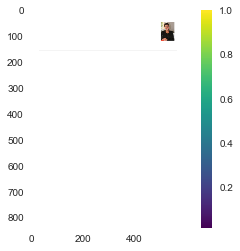

In [21]:
plt.figure()
plt.imshow(images[0], cmap = "viridis")
plt.colorbar()
plt.gca().grid(False)
plt.show()

Now, the next task is to create the label array which encodes the information of original labels. There are four levels for labels: **nothing**, **has_icon**, **has_company** and **has_both**. Based on that, and on the label provided, a vector is created with the following logic.

Let be p an ith-picture in the dataset. Thus, 

   * $Label_i = 1$ if p has nothing inside. On the other hand,  
   * $Label_i = 2$ if p has an icon
   * $Label_i = 3$ if p has a company logo and
   * $Label_i = 4$ if p has both. 

The implementation is as follows and the final shape of the array is shown below.

In [53]:
def encoder(x):
    if x == "nothing":
        y = 1
    elif x == "has_icon":
        y = 2
    elif x == "has_company":
        y = 3
    else:
        y = 4
    return y

label_encode = np.array(list(map(lambda x: encoder(x), label)))
label_encode.shape

(917,)

Finally, is mandatory to create a training and testing samples based on images and label_encode. To do so the following code was developed using Scikit-Learn's train_test_split function. The sizes if each dataset if shown below.

In [54]:
X_train, X_test, labels_train, labels_test = train_test_split(images, label_encode, test_size = 0.2, random_state=42)

print("Features for Training (size): " + str(X_train.shape))
print("Features for Testing (size): " + str(X_test.shape))
print("Labels for Training (size): " + str(labels_train.shape))
print("Labels for Training (size): " + str(labels_test.shape))

Features for Training (size): (733, 840, 594, 3)
Features for Testing (size): (184, 840, 594, 3)
Labels for Training (size): (733,)
Labels for Training (size): (184,)


<hr>
## Training and Testing Process

Based on the dataset provided and after carefully manipulation and pre-processing to create a training and testing datasets (for features and labels) a first modeling task is performed and described as follows.

A Convolutional Neural Network will be trained using a conservative architecture to classify images according to the labels created before. Hence, the CNN will be able to identify is a picture contains **nothing** (No companies' logos nor icons) or contains **icons** or contains **companies** or **both**.

Regarding the architecture of the CNN, a first ***Flatten*** layer is included to put together all the RGB channels. After that, one **Dense Layer (Fully Connected)** is included with an ***ReLu*** activation function. Finally, another ***Dense Layer (Fully Connected)*** is included using a ***Softmax*** activation function to generate the final output. The implementation is shown below.

In [55]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (840, 594, 3)),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

In [56]:
model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [57]:
model.fit(X_train, labels_train, epochs = 5)

Epoch 1/5
733/733 [==============================] - 99s 136ms/step - loss: 2.4170 - acc: 0.8186
Epoch 2/5
733/733 [==============================] - 82s 112ms/step - loss: 2.3089 - acc: 0.8568
Epoch 3/5
733/733 [==============================] - 76s 103ms/step - loss: 2.3089 - acc: 0.8568
Epoch 4/5
733/733 [==============================] - 80s 110ms/step - loss: 2.3089 - acc: 0.8568
Epoch 5/5
733/733 [==============================] - 84s 114ms/step - loss: 2.3089 - acc: 0.8568


In [60]:
test_loss, test_acc = model.evaluate(X_test, labels_test)
print('Test accuracy:', test_acc)

184/184 [==============================] - 14s 78ms/step
Test accuracy: 0.8750000025915063
